# Initial Process to Insert the data

Import data through Kaggle to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ColabNotebooks/inputs"
#changing the working directory
%cd "/content/gdrive/MyDrive/ColabNotebooks/inputs"
#Check the present working directory using pwd command
!pwd

#kaggle API file
! kaggle competitions download -c detect-pneumonia-spring-2022

!ls 

#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

KeyboardInterrupt: ignored

In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



> Indented block


*   Resize the pictures to 224 x 224 & RGB & Panding

*   Get the labels from the file


In [ ]:
def load_normal(norm_path, labels_path):
    norm_files = np.array(os.listdir(norm_path))
    labels = pd.read_csv(labels_path)
    
    norm_images = []
    norm_labels = []
    BLACK =[0,0,0]
    for image in norm_files:
        
        #get the label of each image in a list 
        a = labels[labels["file_name"]==str(image)].index.values
        b = labels.iloc[a]["class_id"].values
        norm_labels.append(b)

        #transform the images 
        path = norm_path + "/" + image
        image = cv2.imread(path)
        im_height, im_width, channels = image.shape
        if im_height > im_width:
          x2 = im_height - im_width
          x1 = 0
        else:
          x1 = im_width - im_height
          x2 = 0
        constant= cv2.copyMakeBorder(image,x1,x1,x2,x2,cv2.BORDER_CONSTANT, value=BLACK)        
        image = cv2.resize(constant, dsize=(224,224))
        norm_images.append(image)

        
    norm_images = np.array(norm_images)
    norm_labels = np.array(norm_labels)
    
    return norm_images, norm_labels

In [ ]:
def load_normal_test(norm_path):

    norm_files = np.array(os.listdir(norm_path))
    norm_images = []
    image_names = []
    BLACK =[0,0,0]

    for image in norm_files:
        
        image_names.append(image)
        #transform the images 
        path = norm_path + "/" + image
        image = cv2.imread(path)
        im_height, im_width, channels = image.shape
        if im_height > im_width:
          x2 = im_height - im_width
          x1 = 0
        else:
          x1 = im_width - im_height
          x2 = 0
        constant= cv2.copyMakeBorder(image,x1,x1,x2,x2,cv2.BORDER_CONSTANT, value=BLACK)        
        image = cv2.resize(constant, dsize=(224,224))
        norm_images.append(image)

        
    norm_images = np.array(norm_images)
    image_names = np.array(image_names)                         
                         
    return norm_images, image_names

In [ ]:
norm_images, norm_labels =  load_normal('/content/gdrive/MyDrive/ColabNotebooks/inputs/train_images', '/content/gdrive/MyDrive/ColabNotebooks/inputs/labels_train.csv')

In [ ]:
norm_images_test, names =  load_normal_test('/content/gdrive/MyDrive/ColabNotebooks/inputs/test_images')

In [ ]:
X_train = norm_images
X_train.shape

(4672, 224, 224, 3)

In [ ]:
y_train = norm_labels
y_train.shape

(4672, 1)

In [ ]:
X_test = norm_images_test
X_test.shape

(1168, 224, 224, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


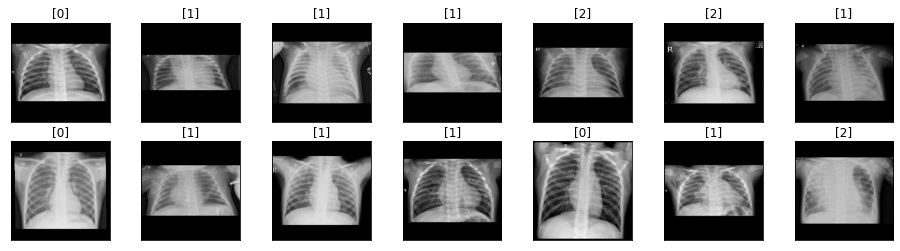

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
#changing the working directory
%cd "/content/gdrive/MyDrive/ColabNotebooks/inputs"

/content/gdrive/MyDrive/ColabNotebooks/inputs


In [ ]:
# Use this to save variables
with open('pneumonia_data3.pickle', 'wb') as f:
    pickle.dump((X_train, y_train), f)# Use this to load variables

In [ ]:
# Use this to save variables
with open('pneumonia_data_test3.pickle', 'wb') as f:
    pickle.dump((X_test), f)# Use this to load variables

In [ ]:
pd.DataFrame(names).to_csv("submission3.csv", index=False, header = ["file_name"])

#Initial Start for all models

In [ ]:
#Already Inserted Previously
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.regularizers import L1L2
from keras.preprocessing.image import ImageDataGenerator
import csv

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#changing the working directory
%cd "/content/gdrive/MyDrive/ColabNotebooks/inputs"

/content/gdrive/MyDrive/ColabNotebooks/inputs


In [ ]:
with open('pneumonia_data3.pickle', 'rb') as f:
    (X_train, y_train) = pickle.load(f)

In [ ]:
with open('pneumonia_data_test3.pickle', 'rb') as f:
    (X_test) = pickle.load(f)

In [ ]:
X_train.shape

(4672, 224, 224, 3)

In [ ]:
X_test.shape

(1168, 224, 224, 3)

In [ ]:
y_train.shape

(4672, 1)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train)

In [ ]:
y_train.shape

(4672, 3)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=32, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=32, subset= "validation")

#Models -> From 22 models only the 16 used on Soft Voting

###EfficientNetB0 ->  Removed on Final Results

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model = Model(inputs=base_model.input, outputs=ouput1)

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-4, decay = 1e-4 * 0.1), metrics=['acc'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB0.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

In [ ]:
history = model.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/25
132/132 [==============================] - 76s 424ms/step - loss: 2.3447 - acc: 0.6540 - val_loss: 2.2193 - val_acc: 0.7516 - lr: 1.0000e-04
Epoch 2/25
132/132 [==============================] - 52s 392ms/step - loss: 2.0571 - acc: 0.7731 - val_loss: 2.0654 - val_acc: 0.7816 - lr: 1.0000e-04
Epoch 3/25
132/132 [==============================] - 52s 389ms/step - loss: 1.9919 - acc: 0.7855 - val_loss: 2.0237 - val_acc: 0.7580 - lr: 1.0000e-04
Epoch 4/25
132/132 [==============================] - 51s 389ms/step - loss: 1.9087 - acc: 0.8131 - val_loss: 1.9222 - val_acc: 0.7880 - lr: 1.0000e-04
Epoch 5/25
132/132 [==============================] - 52s 389ms/step - loss: 1.8656 - acc: 0.8174 - val_loss: 1.8846 - val_acc: 0.8223 - lr: 1.0000e-04
Epoch 6/25
132/132 [==============================] - 52s 390ms/step - loss: 1.8122 - acc: 0.8278 - val_loss: 1.8030 - val_acc: 0.8415 - lr: 1.0000e-04
Epoch 7/25
132/132 [==============================] - 52s 391ms/step - loss: 1.7659 - ac

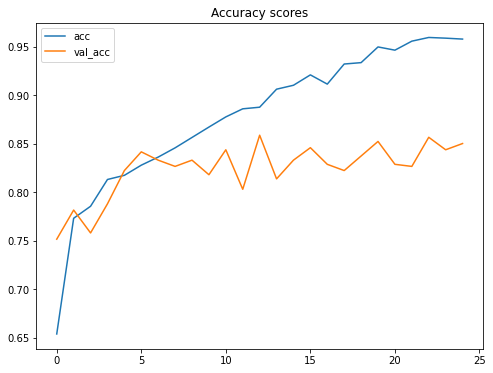

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
model.load_weights("best_model_effB0.hdf5")
preds = model.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission51.csv", index=False)

###EfficienNetB1

In [ ]:
base_model1 = tf.keras.applications.EfficientNetB1(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model1.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model1 = Model(inputs=base_model1.input, outputs=ouput1)

model1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history = model1.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 66s 409ms/step - loss: 2.1128 - acc: 0.7358 - val_loss: 2.2550 - val_acc: 0.7837 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 52s 392ms/step - loss: 1.6266 - acc: 0.8036 - val_loss: 1.4536 - val_acc: 0.7966 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 52s 390ms/step - loss: 1.2768 - acc: 0.8124 - val_loss: 1.2425 - val_acc: 0.7752 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 52s 393ms/step - loss: 0.9949 - acc: 0.8273 - val_loss: 0.8790 - val_acc: 0.8223 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 51s 384ms/step - loss: 0.7947 - acc: 0.8350 - val_loss: 3.7587 - val_acc: 0.5225 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 52s 394ms/step - loss: 0.6548 - acc: 0.8447 - val_loss: 0.5964 - val_acc: 0.8137 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 51s 385ms/step - loss: 0.5273 - acc: 0.8635 - val_loss: 0.

In [ ]:
model1.load_weights("best_model_effB1.hdf5")
preds = model1.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission52.csv", index=False)

### EfficienNetB2

In [ ]:
base_model2 = tf.keras.applications.EfficientNetB2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model2 = Model(inputs=base_model2.input, outputs=ouput1)

model2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history2 = model2.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 67s 416ms/step - loss: 2.1077 - acc: 0.7317 - val_loss: 1.8626 - val_acc: 0.7645 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 53s 396ms/step - loss: 1.6126 - acc: 0.7979 - val_loss: 1.7177 - val_acc: 0.7859 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 52s 389ms/step - loss: 1.2582 - acc: 0.8052 - val_loss: 2.4651 - val_acc: 0.7473 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 52s 395ms/step - loss: 0.9797 - acc: 0.8157 - val_loss: 1.0910 - val_acc: 0.6467 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 53s 397ms/step - loss: 1.0581 - acc: 0.7434 - val_loss: 0.9519 - val_acc: 0.7195 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 53s 397ms/step - loss: 0.8164 - acc: 0.7857 - val_loss: 0.9020 - val_acc: 0.7730 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 53s 397ms/step - loss: 0.7053 - acc: 0.7929 - val_loss: 0.

In [ ]:
model2.load_weights("best_model_effB2.hdf5")
preds = model2.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission53.csv", index=False)

###EfficientNetB3 -> B3_2 & B3_6 Removed on Final Results

In [ ]:
base_model3 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model3 = Model(inputs=base_model3.input, outputs=ouput1)

model3.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history3 = model3.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 92s 514ms/step - loss: 1.6898 - acc: 0.7453 - val_loss: 1.4207 - val_acc: 0.7173 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 61s 460ms/step - loss: 0.9286 - acc: 0.8048 - val_loss: 0.6943 - val_acc: 0.7859 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 61s 464ms/step - loss: 0.5483 - acc: 0.8166 - val_loss: 0.5136 - val_acc: 0.8158 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 461ms/step - loss: 0.3795 - acc: 0.8333 - val_loss: 0.4615 - val_acc: 0.7088 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 61s 462ms/step - loss: 0.3179 - acc: 0.8426 - val_loss: 0.3392 - val_acc: 0.8137 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 60s 452ms/step - loss: 0.2858 - acc: 0.8499 - val_loss: 0.5332 - val_acc: 0.6852 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - ETA: 0s - loss: 0.2773 - acc: 0.8597
Epoch 7: ReduceLROnPl

In [ ]:
model3.load_weights("best_model_effB3.hdf5")
preds = model3.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission54.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history3 = model3.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 82s 498ms/step - loss: 1.6582 - acc: 0.7527 - val_loss: 1.4054 - val_acc: 0.6831 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 60s 451ms/step - loss: 0.9021 - acc: 0.8012 - val_loss: 1.3075 - val_acc: 0.6681 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 61s 457ms/step - loss: 0.5361 - acc: 0.8112 - val_loss: 0.4975 - val_acc: 0.7966 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 59s 447ms/step - loss: 0.3923 - acc: 0.8226 - val_loss: 0.3967 - val_acc: 0.7687 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - ETA: 0s - loss: 0.3402 - acc: 0.8333
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 59s 446ms/step - loss: 0.3402 - acc: 0.8333 - val_loss: 0.5264 - val_acc: 0.6895 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 60s 449ms/step - loss: 0.2769 - acc: 0.8595 - val_

In [ ]:
model3.load_weights("best_model_effB3_vol2.hdf5")
preds = model3.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission54_vol2.csv", index=False)

31) 

In [ ]:
base_model31 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model31.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model31 = Model(inputs=base_model31.input, outputs=ouput1)

model31.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history31 = model31.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 77s 478ms/step - loss: 0.5388 - acc: 0.7565 - val_loss: 0.6924 - val_acc: 0.7645 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 61s 456ms/step - loss: 0.4446 - acc: 0.8064 - val_loss: 0.4197 - val_acc: 0.8094 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 59s 448ms/step - loss: 0.3956 - acc: 0.8195 - val_loss: 0.4476 - val_acc: 0.8030 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - ETA: 0s - loss: 0.3620 - acc: 0.8266
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 60s 449ms/step - loss: 0.3620 - acc: 0.8266 - val_loss: 0.7402 - val_acc: 0.4882 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 61s 457ms/step - loss: 0.2947 - acc: 0.8735 - val_loss: 0.3524 - val_acc: 0.8244 - lr: 3.0000e-04
Epoch 6/50
132/132 [==============================] - 60s 449ms/step - loss: 0.2581 - acc: 0.8908 - 

In [ ]:
model31.load_weights("best_model_effB3_1.hdf5")
preds = model31.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission65.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_1_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history31 = model31.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 82s 492ms/step - loss: 0.5457 - acc: 0.7467 - val_loss: 0.4880 - val_acc: 0.7944 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 68s 517ms/step - loss: 0.4474 - acc: 0.8105 - val_loss: 0.4456 - val_acc: 0.7880 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 61s 460ms/step - loss: 0.4079 - acc: 0.8202 - val_loss: 0.4241 - val_acc: 0.8180 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 60s 453ms/step - loss: 0.3719 - acc: 0.8378 - val_loss: 0.3940 - val_acc: 0.8051 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - ETA: 0s - loss: 0.3366 - acc: 0.8428
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 60s 452ms/step - loss: 0.3366 - acc: 0.8428 - val_loss: 0.5471 - val_acc: 0.6660 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 61s 460ms/step - loss: 0.2642 - acc: 0.8894 - val_

In [ ]:
model31.load_weights("best_model_effB3_1_vol2.hdf5")
preds = model31.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission65_vol2.csv", index=False)

32)

In [ ]:
base_model32 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model32.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'sigmoid')(x)

model32 = Model(inputs=base_model32.input, outputs=ouput1)

model32.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history32 = model32.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 78s 489ms/step - loss: 1.7552 - acc: 0.7396 - val_loss: 1.4863 - val_acc: 0.7409 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 60s 454ms/step - loss: 1.0696 - acc: 0.8000 - val_loss: 0.8772 - val_acc: 0.8158 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 61s 459ms/step - loss: 0.6488 - acc: 0.8197 - val_loss: 0.5593 - val_acc: 0.7944 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 457ms/step - loss: 0.4568 - acc: 0.8347 - val_loss: 0.4788 - val_acc: 0.7944 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 61s 458ms/step - loss: 0.3677 - acc: 0.8376 - val_loss: 0.4429 - val_acc: 0.8030 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 61s 459ms/step - loss: 0.3267 - acc: 0.8423 - val_loss: 0.3952 - val_acc: 0.7645 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 60s 450ms/step - loss: 0.3035 - acc: 0.8599 - val_loss: 0.

In [ ]:
model32.load_weights("best_model_effB3_2.hdf5")
preds = model32.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission66.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_2_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history32 = model32.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 81s 514ms/step - loss: 1.7897 - acc: 0.7356 - val_loss: 1.4909 - val_acc: 0.7816 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 59s 446ms/step - loss: 1.1272 - acc: 0.7902 - val_loss: 0.9439 - val_acc: 0.7537 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.7202 - acc: 0.8012
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 59s 446ms/step - loss: 0.7202 - acc: 0.8012 - val_loss: 1.2123 - val_acc: 0.7238 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 457ms/step - loss: 0.5031 - acc: 0.8409 - val_loss: 0.5017 - val_acc: 0.8009 - lr: 3.0000e-04
Epoch 5/50
132/132 [==============================] - 60s 455ms/step - loss: 0.4114 - acc: 0.8623 - val_loss: 0.4491 - val_acc: 0.8137 - lr: 3.0000e-04
Epoch 6/50
132/132 [==============================] - 61s 459ms/step - loss: 0.3540 - acc: 0.871

In [ ]:
model32.load_weights("best_model_effB3_2_vol2.hdf5")
preds = model32.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission66_vol2.csv", index=False)

33)

In [ ]:
base_model33 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model33.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model33 = Model(inputs=base_model33.input, outputs=ouput1)

model33.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history33 = model33.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 80s 494ms/step - loss: 1.5700 - acc: 0.7484 - val_loss: 1.4567 - val_acc: 0.5246 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 61s 458ms/step - loss: 0.9561 - acc: 0.7902 - val_loss: 0.7686 - val_acc: 0.8051 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 61s 459ms/step - loss: 0.5940 - acc: 0.8214 - val_loss: 0.5365 - val_acc: 0.7859 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 457ms/step - loss: 0.4543 - acc: 0.8228 - val_loss: 0.4306 - val_acc: 0.7923 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 61s 460ms/step - loss: 0.3690 - acc: 0.8309 - val_loss: 0.3772 - val_acc: 0.7966 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 61s 460ms/step - loss: 0.3183 - acc: 0.8366 - val_loss: 0.3657 - val_acc: 0.7816 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 60s 449ms/step - loss: 0.3017 - acc: 0.8559 - val_loss: 0.

In [ ]:
model33.load_weights("best_model_effB3_3.hdf5")
preds = model33.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission67.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_3_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history33 = model33.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 76s 473ms/step - loss: 1.5697 - acc: 0.7398 - val_loss: 1.2292 - val_acc: 0.8094 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 59s 448ms/step - loss: 0.9530 - acc: 0.7960 - val_loss: 0.8177 - val_acc: 0.7987 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.5973 - acc: 0.8205
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 59s 448ms/step - loss: 0.5973 - acc: 0.8205 - val_loss: 0.6276 - val_acc: 0.7452 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 461ms/step - loss: 0.4285 - acc: 0.8523 - val_loss: 0.4241 - val_acc: 0.8308 - lr: 3.0000e-04
Epoch 5/50
132/132 [==============================] - 59s 446ms/step - loss: 0.3631 - acc: 0.8683 - val_loss: 0.4132 - val_acc: 0.8223 - lr: 3.0000e-04
Epoch 6/50
132/132 [==============================] - ETA: 0s - loss: 0.3136 - acc: 0.8873
Epoch

In [ ]:
model33.load_weights("best_model_effB3_3_vol2.hdf5")
preds = model33.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission67_vol2.csv", index=False)

34)

In [ ]:
base_model34 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model34.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model34 = Model(inputs=base_model34.input, outputs=ouput1)

model34.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_4.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history34 = model34.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 77s 473ms/step - loss: 1.1164 - acc: 0.7432 - val_loss: 1.2949 - val_acc: 0.6081 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 61s 456ms/step - loss: 0.7312 - acc: 0.7924 - val_loss: 0.7025 - val_acc: 0.7537 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 60s 455ms/step - loss: 0.4956 - acc: 0.8205 - val_loss: 0.4583 - val_acc: 0.7923 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 61s 460ms/step - loss: 0.3907 - acc: 0.8283 - val_loss: 0.3841 - val_acc: 0.8009 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 59s 448ms/step - loss: 0.3131 - acc: 0.8433 - val_loss: 0.4088 - val_acc: 0.7901 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 61s 461ms/step - loss: 0.2853 - acc: 0.8518 - val_loss: 0.3288 - val_acc: 0.8223 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 59s 448ms/step - loss: 0.2676 - acc: 0.8592 - val_loss: 0.

In [ ]:
model34.load_weights("best_model_effB3_4.hdf5")
preds = model34.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission68.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_4_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history34 = model34.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 117s 683ms/step - loss: 1.1094 - acc: 0.7391 - val_loss: 0.8978 - val_acc: 0.7495 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 86s 646ms/step - loss: 0.7211 - acc: 0.7990 - val_loss: 0.6638 - val_acc: 0.7901 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 86s 648ms/step - loss: 0.4933 - acc: 0.8214 - val_loss: 0.4531 - val_acc: 0.8009 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 85s 638ms/step - loss: 0.3716 - acc: 0.8307 - val_loss: 0.6413 - val_acc: 0.5675 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - ETA: 0s - loss: 0.3299 - acc: 0.8235
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 84s 635ms/step - loss: 0.3299 - acc: 0.8235 - val_loss: 0.3975 - val_acc: 0.7859 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 86s 646ms/step - loss: 0.2584 - acc: 0.8697 - val

In [ ]:
model34.load_weights("best_model_effB3_4_vol2.hdf5")
preds = model34.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission68_vol2.csv", index=False)

35)

In [ ]:
base_model35 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model35.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'sigmoid')(x)

model35 = Model(inputs=base_model35.input, outputs=ouput1)

model35.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_5.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history35 = model35.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/20
132/132 [==============================] - 78s 482ms/step - loss: 1.7684 - acc: 0.7386 - val_loss: 1.4336 - val_acc: 0.7602 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 60s 454ms/step - loss: 1.0814 - acc: 0.8050 - val_loss: 0.8540 - val_acc: 0.8116 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 60s 450ms/step - loss: 0.6843 - acc: 0.8138 - val_loss: 0.5644 - val_acc: 0.8244 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 60s 455ms/step - loss: 0.4615 - acc: 0.8254 - val_loss: 0.4187 - val_acc: 0.7987 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 60s 454ms/step - loss: 0.3706 - acc: 0.8400 - val_loss: 0.4150 - val_acc: 0.8030 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 60s 453ms/step - loss: 0.3371 - acc: 0.8466 - val_loss: 0.3942 - val_acc: 0.8030 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - 60s 452ms/step - loss: 0.3220 - acc: 0.8480 - val_loss: 0.

In [ ]:
model35.load_weights("best_model_effB3_5.hdf5")
preds = model35.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission69.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_5_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history35 = model35.fit(train_gen, epochs=35, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/35
132/132 [==============================] - 101s 660ms/step - loss: 1.7355 - acc: 0.7477 - val_loss: 1.4295 - val_acc: 0.7216 - lr: 0.0010
Epoch 2/35
132/132 [==============================] - 86s 646ms/step - loss: 1.0232 - acc: 0.7974 - val_loss: 0.8426 - val_acc: 0.7923 - lr: 0.0010
Epoch 3/35
132/132 [==============================] - 84s 634ms/step - loss: 0.6304 - acc: 0.8105 - val_loss: 0.5450 - val_acc: 0.7859 - lr: 0.0010
Epoch 4/35
132/132 [==============================] - 85s 645ms/step - loss: 0.4639 - acc: 0.8197 - val_loss: 0.4158 - val_acc: 0.8223 - lr: 0.0010
Epoch 5/35
132/132 [==============================] - 84s 633ms/step - loss: 0.3779 - acc: 0.8369 - val_loss: 0.4200 - val_acc: 0.7859 - lr: 0.0010
Epoch 6/35
132/132 [==============================] - ETA: 0s - loss: 0.3422 - acc: 0.8376
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 84s 633ms/step - loss: 0.3422 - acc: 0.8376 - val

In [ ]:
model35.load_weights("best_model_effB3_5_vol2.hdf5")
preds = model35.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission69_vol2.csv", index=False)

36)

In [ ]:
base_model36 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model36.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'sigmoid')(x)

model36 = Model(inputs=base_model36.input, outputs=ouput1)

model36.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_6.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history36 = model36.fit(train_gen, epochs=60, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/60
132/132 [==============================] - 75s 471ms/step - loss: 1.7492 - acc: 0.7444 - val_loss: 1.4678 - val_acc: 0.6981 - lr: 0.0010
Epoch 2/60
132/132 [==============================] - 61s 460ms/step - loss: 1.0570 - acc: 0.7957 - val_loss: 1.1470 - val_acc: 0.6745 - lr: 0.0010
Epoch 3/60
132/132 [==============================] - 61s 457ms/step - loss: 0.6548 - acc: 0.8174 - val_loss: 0.6082 - val_acc: 0.7580 - lr: 0.0010
Epoch 4/60
132/132 [==============================] - 61s 457ms/step - loss: 0.4551 - acc: 0.8328 - val_loss: 0.4720 - val_acc: 0.7987 - lr: 0.0010
Epoch 5/60
132/132 [==============================] - 61s 457ms/step - loss: 0.3764 - acc: 0.8326 - val_loss: 0.4345 - val_acc: 0.7730 - lr: 0.0010
Epoch 6/60
132/132 [==============================] - 61s 457ms/step - loss: 0.3332 - acc: 0.8523 - val_loss: 0.3688 - val_acc: 0.8073 - lr: 0.0010
Epoch 7/60
132/132 [==============================] - 61s 458ms/step - loss: 0.3078 - acc: 0.8485 - val_loss: 0.

In [ ]:
model36.load_weights("best_model_effB3_6.hdf5")
preds = model36.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission70.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_6_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history36 = model36.fit(train_gen, epochs=60, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/60
132/132 [==============================] - 104s 673ms/step - loss: 1.7328 - acc: 0.7432 - val_loss: 1.7526 - val_acc: 0.7495 - lr: 0.0010
Epoch 2/60
132/132 [==============================] - 86s 649ms/step - loss: 1.0308 - acc: 0.8057 - val_loss: 0.8516 - val_acc: 0.7816 - lr: 0.0010
Epoch 3/60
132/132 [==============================] - 84s 630ms/step - loss: 0.6365 - acc: 0.8117 - val_loss: 0.6479 - val_acc: 0.7709 - lr: 0.0010
Epoch 4/60
132/132 [==============================] - ETA: 0s - loss: 0.4479 - acc: 0.8281
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 83s 629ms/step - loss: 0.4479 - acc: 0.8281 - val_loss: 0.4947 - val_acc: 0.7645 - lr: 0.0010
Epoch 5/60
132/132 [==============================] - 85s 641ms/step - loss: 0.3401 - acc: 0.8630 - val_loss: 0.3568 - val_acc: 0.8437 - lr: 3.0000e-04
Epoch 6/60
132/132 [==============================] - 83s 630ms/step - loss: 0.2727 - acc: 0.8892 -

In [ ]:
model36.load_weights("best_model_effB3_6_vol2.hdf5")
preds = model36.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission70_vol2.csv", index=False)

37)

In [ ]:
base_model37 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model37.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model37 = Model(inputs=base_model37.input, outputs=ouput1)

model37.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_7.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history37 = model37.fit(train_gen, epochs=60, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/60
132/132 [==============================] - 84s 512ms/step - loss: 1.6017 - acc: 0.7581 - val_loss: 1.0996 - val_acc: 0.7794 - lr: 0.0010
Epoch 2/60
132/132 [==============================] - 61s 464ms/step - loss: 0.7945 - acc: 0.8029 - val_loss: 0.5698 - val_acc: 0.8009 - lr: 0.0010
Epoch 3/60
132/132 [==============================] - 62s 467ms/step - loss: 0.4592 - acc: 0.8126 - val_loss: 0.5153 - val_acc: 0.7794 - lr: 0.0010
Epoch 4/60
132/132 [==============================] - 69s 518ms/step - loss: 0.3498 - acc: 0.8380 - val_loss: 0.3975 - val_acc: 0.7709 - lr: 0.0010
Epoch 5/60
132/132 [==============================] - 67s 506ms/step - loss: 0.3183 - acc: 0.8407 - val_loss: 0.3613 - val_acc: 0.8223 - lr: 0.0010
Epoch 6/60
132/132 [==============================] - 68s 510ms/step - loss: 0.2820 - acc: 0.8537 - val_loss: 0.3116 - val_acc: 0.8116 - lr: 0.0010
Epoch 7/60
132/132 [==============================] - 60s 453ms/step - loss: 0.2675 - acc: 0.8559 - val_loss: 0.

In [ ]:
model37.load_weights("best_model_effB3_7.hdf5")
preds = model37.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission71.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_7_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history37 = model37.fit(train_gen, epochs=60, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/60
132/132 [==============================] - 101s 660ms/step - loss: 1.6541 - acc: 0.7501 - val_loss: 1.2589 - val_acc: 0.7923 - lr: 0.0010
Epoch 2/60
132/132 [==============================] - 84s 631ms/step - loss: 0.8735 - acc: 0.7993 - val_loss: 0.9295 - val_acc: 0.6338 - lr: 0.0010
Epoch 3/60
132/132 [==============================] - ETA: 0s - loss: 0.4874 - acc: 0.8171
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 83s 629ms/step - loss: 0.4874 - acc: 0.8171 - val_loss: 0.5778 - val_acc: 0.7323 - lr: 0.0010
Epoch 4/60
132/132 [==============================] - 85s 639ms/step - loss: 0.3404 - acc: 0.8499 - val_loss: 0.3527 - val_acc: 0.8287 - lr: 3.0000e-04
Epoch 5/60
132/132 [==============================] - 83s 626ms/step - loss: 0.2771 - acc: 0.8768 - val_loss: 0.3548 - val_acc: 0.8223 - lr: 3.0000e-04
Epoch 6/60
132/132 [==============================] - 85s 643ms/step - loss: 0.2470 - acc: 0.88

In [ ]:
model37.load_weights("best_model_effB3_7_vol2.hdf5")
preds = model37.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission71_vol2.csv", index=False)

38)

In [ ]:
base_model38 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model38.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model38 = Model(inputs=base_model38.input, outputs=ouput1)

model38.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_8.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history38 = model38.fit(train_gen, epochs=80, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/80
132/132 [==============================] - 76s 472ms/step - loss: 1.1023 - acc: 0.7512 - val_loss: 1.0913 - val_acc: 0.6488 - lr: 0.0010
Epoch 2/80
132/132 [==============================] - 60s 455ms/step - loss: 0.7122 - acc: 0.8062 - val_loss: 0.6104 - val_acc: 0.7837 - lr: 0.0010
Epoch 3/80
132/132 [==============================] - 59s 446ms/step - loss: 0.4743 - acc: 0.8254 - val_loss: 0.6584 - val_acc: 0.6403 - lr: 0.0010
Epoch 4/80
132/132 [==============================] - 60s 456ms/step - loss: 0.3759 - acc: 0.8266 - val_loss: 0.4159 - val_acc: 0.7837 - lr: 0.0010
Epoch 5/80
132/132 [==============================] - 61s 457ms/step - loss: 0.3312 - acc: 0.8350 - val_loss: 0.3529 - val_acc: 0.7837 - lr: 0.0010
Epoch 6/80
132/132 [==============================] - 61s 457ms/step - loss: 0.2900 - acc: 0.8385 - val_loss: 0.3382 - val_acc: 0.8009 - lr: 0.0010
Epoch 7/80
132/132 [==============================] - 61s 457ms/step - loss: 0.2752 - acc: 0.8535 - val_loss: 0.

In [ ]:
model38.load_weights("best_model_effB3_8.hdf5")
preds = model38.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission72.csv", index=False)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effB3_8_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_acc', restore_best_weights=True)

history38 = model38.fit(train_gen, epochs=80, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/80
132/132 [==============================] - 100s 655ms/step - loss: 1.1049 - acc: 0.7441 - val_loss: 1.0144 - val_acc: 0.7131 - lr: 0.0010
Epoch 2/80
132/132 [==============================] - 85s 641ms/step - loss: 0.7147 - acc: 0.7988 - val_loss: 0.5825 - val_acc: 0.7901 - lr: 0.0010
Epoch 3/80
132/132 [==============================] - 83s 628ms/step - loss: 0.4835 - acc: 0.8150 - val_loss: 0.5238 - val_acc: 0.7687 - lr: 0.0010
Epoch 4/80
132/132 [==============================] - ETA: 0s - loss: 0.3768 - acc: 0.8361
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 83s 629ms/step - loss: 0.3768 - acc: 0.8361 - val_loss: 0.4569 - val_acc: 0.7430 - lr: 0.0010
Epoch 5/80
132/132 [==============================] - 85s 644ms/step - loss: 0.2856 - acc: 0.8652 - val_loss: 0.3333 - val_acc: 0.8137 - lr: 3.0000e-04
Epoch 6/80
132/132 [==============================] - 83s 627ms/step - loss: 0.2441 - acc: 0.8882 -

In [ ]:
model38.load_weights("best_model_effB3_8_vol2.hdf5")
preds = model38.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission72_vol2.csv", index=False)

###EfficientNetV2B0


In [ ]:
base_model4 = tf.keras.applications.EfficientNetV2B0(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model4.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model4 = Model(inputs=base_model4.input, outputs=ouput1)

model4.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

24289280/24274472 [==============================] - 0s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effV2B0.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history4 = model4.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/25
132/132 [==============================] - 63s 403ms/step - loss: 2.0764 - acc: 0.7520 - val_loss: 1.7443 - val_acc: 0.8030 - lr: 0.0010
Epoch 2/25
132/132 [==============================] - 53s 400ms/step - loss: 1.5988 - acc: 0.8086 - val_loss: 1.5081 - val_acc: 0.7709 - lr: 0.0010
Epoch 3/25
132/132 [==============================] - 51s 385ms/step - loss: 1.2613 - acc: 0.8088 - val_loss: 1.1855 - val_acc: 0.7944 - lr: 0.0010
Epoch 4/25
132/132 [==============================] - 51s 387ms/step - loss: 0.9894 - acc: 0.8150 - val_loss: 0.9316 - val_acc: 0.7859 - lr: 0.0010
Epoch 5/25
132/132 [==============================] - 51s 386ms/step - loss: 0.7816 - acc: 0.8316 - val_loss: 0.7755 - val_acc: 0.8073 - lr: 0.0010
Epoch 6/25
132/132 [==============================] - 51s 389ms/step - loss: 0.6321 - acc: 0.8411 - val_loss: 0.6085 - val_acc: 0.8223 - lr: 0.0010
Epoch 7/25
132/132 [==============================] - 51s 387ms/step - loss: 0.5285 - acc: 0.8502 - val_loss: 0.

In [ ]:
model4.load_weights("best_model_effV2B0.hdf5")
preds = model4.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission55.csv", index=False)

###EfficientNetV2B1

In [ ]:
base_model5 = tf.keras.applications.EfficientNetV2B1(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model5.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model5 = Model(inputs=base_model5.input, outputs=ouput1)

model5.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effV2B1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history5 = model5.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/25
132/132 [==============================] - 69s 430ms/step - loss: 2.0388 - acc: 0.7536 - val_loss: 1.7417 - val_acc: 0.7859 - lr: 0.0010
Epoch 2/25
132/132 [==============================] - 54s 408ms/step - loss: 1.5591 - acc: 0.7950 - val_loss: 1.3031 - val_acc: 0.8351 - lr: 0.0010
Epoch 3/25
132/132 [==============================] - 54s 405ms/step - loss: 1.1790 - acc: 0.8174 - val_loss: 1.0184 - val_acc: 0.8308 - lr: 0.0010
Epoch 4/25
132/132 [==============================] - 54s 405ms/step - loss: 0.9325 - acc: 0.8183 - val_loss: 0.8075 - val_acc: 0.8351 - lr: 0.0010
Epoch 5/25
132/132 [==============================] - 53s 403ms/step - loss: 0.7205 - acc: 0.8347 - val_loss: 0.7073 - val_acc: 0.8094 - lr: 0.0010
Epoch 6/25
132/132 [==============================] - 53s 399ms/step - loss: 0.5782 - acc: 0.8514 - val_loss: 0.7917 - val_acc: 0.7580 - lr: 0.0010
Epoch 7/25
132/132 [==============================] - 54s 405ms/step - loss: 0.4961 - acc: 0.8606 - val_loss: 0.

In [ ]:
model5.load_weights("best_model_effV2B1.hdf5")
preds = model5.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission41.csv", index=False)

###EfficientNetV2B2 -> Removed on Final Results

In [ ]:
base_model6 = tf.keras.applications.EfficientNetV2B2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model6.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model6 = Model(inputs=base_model6.input, outputs=ouput1)

model6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effV2B2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history6 = model6.fit(train_gen, epochs=26, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/26
132/132 [==============================] - 68s 421ms/step - loss: 2.1432 - acc: 0.7375 - val_loss: 1.8277 - val_acc: 0.7901 - lr: 0.0010
Epoch 2/26
132/132 [==============================] - 55s 415ms/step - loss: 1.6833 - acc: 0.7788 - val_loss: 1.4623 - val_acc: 0.8051 - lr: 0.0010
Epoch 3/26
132/132 [==============================] - 55s 412ms/step - loss: 1.3108 - acc: 0.8010 - val_loss: 1.0951 - val_acc: 0.8223 - lr: 0.0010
Epoch 4/26
132/132 [==============================] - 54s 407ms/step - loss: 1.0322 - acc: 0.8090 - val_loss: 0.9331 - val_acc: 0.8009 - lr: 0.0010
Epoch 5/26
132/132 [==============================] - 54s 408ms/step - loss: 0.8992 - acc: 0.7931 - val_loss: 0.8836 - val_acc: 0.7987 - lr: 0.0010
Epoch 6/26
132/132 [==============================] - 53s 402ms/step - loss: 0.8437 - acc: 0.7717 - val_loss: 2.8764 - val_acc: 0.6831 - lr: 0.0010
Epoch 7/26
132/132 [==============================] - ETA: 0s - loss: 0.7614 - acc: 0.7636
Epoch 7: ReduceLROnPl

In [ ]:
model6.load_weights("best_model_effV2B2.hdf5")
preds = model6.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission42.csv", index=False)

###EfficientNetV2B3

In [ ]:
base_model7 = tf.keras.applications.EfficientNetV2B3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model7.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model7 = Model(inputs=base_model7.input, outputs=ouput1)

model7.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

52617216/52606240 [==============================] - 1s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effV2B3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history7 = model7.fit(train_gen, epochs=26, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/26
132/132 [==============================] - 74s 446ms/step - loss: 2.1729 - acc: 0.7187 - val_loss: 1.8387 - val_acc: 0.7859 - lr: 0.0010
Epoch 2/26
132/132 [==============================] - 55s 413ms/step - loss: 1.6485 - acc: 0.7936 - val_loss: 1.4412 - val_acc: 0.8094 - lr: 0.0010
Epoch 3/26
132/132 [==============================] - 55s 417ms/step - loss: 1.2910 - acc: 0.8055 - val_loss: 1.0758 - val_acc: 0.8394 - lr: 0.0010
Epoch 4/26
132/132 [==============================] - 55s 417ms/step - loss: 0.9843 - acc: 0.8143 - val_loss: 0.9656 - val_acc: 0.7666 - lr: 0.0010
Epoch 5/26
132/132 [==============================] - 55s 416ms/step - loss: 0.8081 - acc: 0.8117 - val_loss: 0.6967 - val_acc: 0.8373 - lr: 0.0010
Epoch 6/26
132/132 [==============================] - 55s 414ms/step - loss: 0.6213 - acc: 0.8380 - val_loss: 0.5853 - val_acc: 0.8394 - lr: 0.0010
Epoch 7/26
132/132 [==============================] - 56s 419ms/step - loss: 0.5456 - acc: 0.8445 - val_loss: 0.

In [ ]:
model7.load_weights("best_model_effV2B3.hdf5")
preds = model7.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission43.csv", index=False)

###EfficientNetV2M -> base_model19 Removed on Final Results

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=40, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=40, subset= "validation")

In [ ]:
base_model14 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model14.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(224, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(224, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model14 = Model(inputs=base_model14.input, outputs=ouput1)
model14.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])



In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_50epochs_40.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

#fit
history = model14.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])

Epoch 1/50
106/106 [==============================] - 144s 1s/step - loss: 1.3349 - acc: 0.7334 - val_loss: 1.1964 - val_acc: 0.7752 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - 109s 1s/step - loss: 1.0486 - acc: 0.7936 - val_loss: 1.1152 - val_acc: 0.7216 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - ETA: 0s - loss: 0.8915 - acc: 0.8081
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
106/106 [==============================] - 112s 1s/step - loss: 0.8915 - acc: 0.8081 - val_loss: 2.5287 - val_acc: 0.6060 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 115s 1s/step - loss: 0.7764 - acc: 0.8162 - val_loss: 0.7484 - val_acc: 0.8201 - lr: 3.0000e-04
Epoch 5/50
106/106 [==============================] - 115s 1s/step - loss: 0.6601 - acc: 0.8568 - val_loss: 0.6927 - val_acc: 0.8373 - lr: 3.0000e-04
Epoch 6/50
106/106 [==============================] - 112s 1s/step - loss: 0.6199 - acc: 0.8576 - val_loss

In [ ]:
model14.load_weights("best_model_EfficientNetV2M_50epochs_40.hdf5")
preds = model14.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_50epochs_40.csv", index=False)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=45, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=45, subset= "validation")

In [ ]:
base_model16 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model16 = Model(inputs=base_model16.input, outputs=ouput1)
model16.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

214212608/214201816 [==============================] - 1s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_vol2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

#fit
history = model16.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])

Epoch 1/10
104/104 [==============================] - 210s 2s/step - loss: 2.0884 - acc: 0.7453 - val_loss: 2.0835 - val_acc: 0.7018 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - 172s 2s/step - loss: 1.6448 - acc: 0.7928 - val_loss: 1.5949 - val_acc: 0.7339 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - 173s 2s/step - loss: 1.2627 - acc: 0.8183 - val_loss: 1.0442 - val_acc: 0.8555 - lr: 0.0010
Epoch 4/10
104/104 [==============================] - 172s 2s/step - loss: 0.9819 - acc: 0.8221 - val_loss: 0.8369 - val_acc: 0.8553 - lr: 0.0010
Epoch 5/10
104/104 [==============================] - ETA: 0s - loss: 0.8213 - acc: 0.8283
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
104/104 [==============================] - 171s 2s/step - loss: 0.8213 - acc: 0.8283 - val_loss: 0.8169 - val_acc: 0.7992 - lr: 0.0010
Epoch 6/10
104/104 [==============================] - 174s 2s/step - loss: 0.7131 - acc: 0.8343 - val_loss: 0.6027

In [ ]:
model16.load_weights('best_model_EfficientNetV2M_vol2.hdf5')
preds = model16.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_vol2.csv", index=False)

In [ ]:
base_model19 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model19.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model19 = Model(inputs=base_model19.input, outputs=ouput1)
model19.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_vol6.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

#fit
history = model19.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])

Epoch 1/10
104/104 [==============================] - 200s 2s/step - loss: 2.0952 - acc: 0.7380 - val_loss: 1.7505 - val_acc: 0.8266 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - 170s 2s/step - loss: 1.6983 - acc: 0.7770 - val_loss: 1.5436 - val_acc: 0.7975 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - 174s 2s/step - loss: 1.3640 - acc: 0.7729 - val_loss: 1.1381 - val_acc: 0.8307 - lr: 0.0010
Epoch 4/10
104/104 [==============================] - 171s 2s/step - loss: 1.1220 - acc: 0.7920 - val_loss: 0.9992 - val_acc: 0.8035 - lr: 0.0010
Epoch 5/10
104/104 [==============================] - ETA: 0s - loss: 1.0344 - acc: 0.7601
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
104/104 [==============================] - 171s 2s/step - loss: 1.0344 - acc: 0.7601 - val_loss: 0.8978 - val_acc: 0.7821 - lr: 0.0010
Epoch 6/10
104/104 [==============================] - 171s 2s/step - loss: 0.8465 - acc: 0.7964 - val_loss: 0.7746

In [ ]:
model19.load_weights('best_model_EfficientNetV2M_vol6.hdf5')
preds = model19.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_vol6.csv", index=False)

In [ ]:
base_model20 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model20.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model20 = Model(inputs=base_model20.input, outputs=ouput1)
model20.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_vol7.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

#fit
history = model20.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])

Epoch 1/50
104/104 [==============================] - 209s 2s/step - loss: 2.1217 - acc: 0.7179 - val_loss: 1.8074 - val_acc: 0.8039 - lr: 0.0010
Epoch 2/50
104/104 [==============================] - 170s 2s/step - loss: 1.6724 - acc: 0.8031 - val_loss: 1.5628 - val_acc: 0.7990 - lr: 0.0010
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 1.5122 - acc: 0.7661
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
104/104 [==============================] - 170s 2s/step - loss: 1.5122 - acc: 0.7661 - val_loss: 4.3048 - val_acc: 0.6203 - lr: 0.0010
Epoch 4/50
104/104 [==============================] - 173s 2s/step - loss: 1.2637 - acc: 0.7864 - val_loss: 1.1842 - val_acc: 0.8061 - lr: 3.0000e-04
Epoch 5/50
104/104 [==============================] - 172s 2s/step - loss: 1.1417 - acc: 0.8097 - val_loss: 1.0507 - val_acc: 0.8266 - lr: 3.0000e-04
Epoch 6/50
104/104 [==============================] - 173s 2s/step - loss: 1.0201 - acc: 0.8281 - val_loss

In [ ]:
model20.load_weights('best_model_EfficientNetV2M_vol7.hdf5')
preds = model20.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_vol7.csv", index=False)

###MobileNet

In [ ]:
base_model8 = tf.keras.applications.MobileNet(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model8.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model8 = Model(inputs=base_model8.input, outputs=ouput1)

model8.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])
model8.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_MN.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history8 = model8.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/20
132/132 [==============================] - 68s 487ms/step - loss: 2.0216 - acc: 0.7389 - val_loss: 2.1545 - val_acc: 0.7816 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 56s 423ms/step - loss: 1.5712 - acc: 0.8017 - val_loss: 1.7701 - val_acc: 0.7131 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 53s 398ms/step - loss: 1.2306 - acc: 0.8162 - val_loss: 1.1688 - val_acc: 0.8094 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 54s 410ms/step - loss: 0.9619 - acc: 0.8288 - val_loss: 0.8996 - val_acc: 0.8373 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 53s 399ms/step - loss: 0.7599 - acc: 0.8361 - val_loss: 0.8362 - val_acc: 0.7966 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 53s 399ms/step - loss: 0.6119 - acc: 0.8485 - val_loss: 0.6912 - val_acc: 0.7923 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - 52s 392ms/step - loss: 0.5250 - acc: 0.8623 - val_loss: 0.

In [ ]:
model8.load_weights("best_model_MN.hdf5")
preds = model8.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission46.csv", index=False)

###MobileNetV2 ->  Removed on Final Results

In [ ]:
base_model9 = tf.keras.applications.MobileNetV2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model9.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model9 = Model(inputs=base_model9.input, outputs=ouput1)

model9.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-3, decay = 1e-3 * 0.1), metrics=['acc'])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_MNV2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history9 = model9.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/20
132/132 [==============================] - 60s 412ms/step - loss: 2.1421 - acc: 0.7146 - val_loss: 5.1924 - val_acc: 0.2998 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 54s 405ms/step - loss: 1.6561 - acc: 0.7857 - val_loss: 4.8682 - val_acc: 0.4069 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 53s 401ms/step - loss: 1.2740 - acc: 0.7990 - val_loss: 2.7762 - val_acc: 0.4347 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 53s 401ms/step - loss: 1.0031 - acc: 0.8209 - val_loss: 1.2577 - val_acc: 0.7666 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 52s 395ms/step - loss: 0.8178 - acc: 0.8140 - val_loss: 3.0075 - val_acc: 0.4861 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 53s 397ms/step - loss: 0.6889 - acc: 0.8193 - val_loss: 1.0821 - val_acc: 0.6253 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - 52s 395ms/step - loss: 0.5899 - acc: 0.8333 - val_loss: 1.

In [ ]:
model9.load_weights("best_model_MNV2.hdf5")
preds = model9.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission47.csv", index=False)

#Majority Voting

###Get the predictions -> Keep only the 16 predictions

In [1]:
#removed 
#model.load_weights("best_model_effB0.hdf5")
#preds = model.predict(X_test) 

In [ ]:
model1.load_weights("best_model_effB1.hdf5")
preds1 = model1.predict(X_test) 

In [ ]:
model2.load_weights("best_model_effB2.hdf5")
preds2 = model2.predict(X_test) 

In [ ]:
model3.load_weights("best_model_effB3.hdf5")
preds3 = model3.predict(X_test) 

In [ ]:
model31.load_weights("best_model_effB3_1.hdf5")
preds31 = model31.predict(X_test)

In [ ]:
#removed 
#model32.load_weights("best_model_effB3_2.hdf5")
#preds32 = model32.predict(X_test) 

In [ ]:
model33.load_weights("best_model_effB3_3.hdf5")
preds33 = model33.predict(X_test)

In [ ]:
model34.load_weights("best_model_effB3_4.hdf5")
preds34 = model34.predict(X_test)

In [ ]:
model35.load_weights("best_model_effB3_5.hdf5")
preds35 = model35.predict(X_test)

In [ ]:
#removed
#model36.load_weights("best_model_effB3_6.hdf5")
#preds36 = model36.predict(X_test)

In [ ]:
model37.load_weights("best_model_effB3_7.hdf5")
preds37 = model37.predict(X_test)

In [ ]:
model38.load_weights("best_model_effB3_8.hdf5")
preds38 = model38.predict(X_test)

In [ ]:
model4.load_weights("best_model_effV2B0.hdf5")
preds4 = model4.predict(X_test)

In [ ]:
model5.load_weights("best_model_effV2B1.hdf5")
preds5 = model5.predict(X_test)

In [ ]:
#removed
#model6.load_weights("best_model_effV2B2.hdf5")
#preds6 = model6.predict(X_test)

In [ ]:
model7.load_weights("best_model_effV2B3.hdf5")
preds7 = model7.predict(X_test)

In [ ]:
model8.load_weights("best_model_MN.hdf5")
preds8 = model8.predict(X_test) 

In [ ]:
#removed
#model9.load_weights("best_model_MNV2.hdf5")
#preds9 = model9.predict(X_test) 

In [ ]:
model14.load_weights('best_model_EfficientNetV2M_50epochs_40.hdf5')
preds14 = model14.predict(X_test)

In [ ]:
model16.load_weights('best_model_EfficientNetV2M_vol2.hdf5')
preds16 = model16.predict(X_test) 

In [ ]:
#removed
#model19.load_weights('best_model_EfficientNetV2M_vol6.hdf5')
#preds19 = model19.predict(X_test)

In [ ]:
model20.load_weights('best_model_EfficientNetV2M_vol7.hdf5')
preds20 = model20.predict(X_test)

###Soft voting

In [ ]:
a = np.mean( np.array([preds1, preds2, preds3, preds31, preds33, preds34, preds35, preds37, preds38, preds4, preds5, preds7, preds8, preds14, preds16, preds20]), axis=0 )
final_labels = one_hot_encoder.inverse_transform(a)
final_labels

In [ ]:
pred = pd.DataFrame(final_labels, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_last_day_2.csv.csv", index=False)